In [1]:
# Import packages 
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')
# This next command is specifically for Jupyter Notebook
%matplotlib notebook

import requests
from IPython.display import Image
import pandas as pd

In [2]:
# Load data
df = pd.read_csv('data/incomes.txt', names=['income'])

In [3]:
incomes = df['income']
incomes.describe()

count       200.000000
mean      85276.823606
std       18037.692869
min       47628.560636
25%       71850.308175
50%       83864.444560
75%       96059.995074
max      139079.351549
Name: income, dtype: float64

## Problem 1.a

Plot the sample data. 

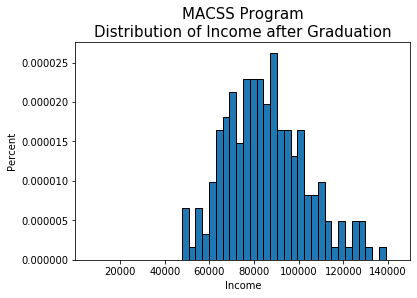

In [4]:
num_bins = 30
plt.hist(incomes, num_bins, density=True, edgecolor='k') # `normed` argument has been deprecated by `matplotlib.pyplot.hist`
plt.title('MACSS Program\nDistribution of Income after Graduation', fontsize=15)
plt.xlabel(r'Income')
plt.ylabel(r'Percent')
plt.xlim([1, 150000])
plt.show()

## Problem 1.b

GMM
- R (No. of moment conditions): 2 
- Moment conditions
    - mean
    - standard deviation
- Weighting matrix: identity matrix

In [5]:
# Define a function that generates values of a lognormal pdf

def trunc_lognorm_pdf(x_vals, mu, sigma, cut_lb='None', cut_ub='None'):
    
    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm(sigma, scale=np.exp(mu)).cdf(cut_lb)
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm(sigma, scale=np.exp(mu)).cdf(cut_ub)
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm(sigma, scale=np.exp(mu)).cdf(cut_ub) -
                       sts.lognorm(sigma, scale=np.exp(mu)).cdf(cut_lb))
            
    pdf_vals =  sts.lognorm(sigma, scale=np.exp(mu)).pdf(x_vals) / prob_notcut
    
    return pdf_vals

In [6]:
# Define the functions that calculate 
# data and model moment, the error vector, and the criterion

def data_moments(xvals):

    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data


def model_moments(mu, sigma, cut_lb, cut_ub):
   
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (mean_model, m_m_err) = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub) 
    (var_model, v_m_err) = intgr.quad(x2fx, cut_lb, cut_ub)
    
    return mean_model, np.sqrt(var_model)


def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):

    mean_data, var_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [var_data]])
    mean_model, var_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [var_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [7]:
# Perfom GMM with R = 2, W = I
mu_init = 11
sig_init = 0.5
cut_lb = 0.0
cut_ub = 150000.0
params_init = np.array([mu_init, sig_init])
W_hat1_2 = np.eye(2)
gmm_args = (incomes, cut_lb, cut_ub, W_hat1_2)
results1_2 = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM1_2, sig_GMM1_2 = results1_2.x
print('mu_GMM1 =', mu_GMM1_2, ' sig_GMM1 =', sig_GMM1_2)
results1_2

mu_GMM1 = 11.333533482547018  sig_GMM1 = 0.21386191435240126


      fun: array([[6.35762886e-16]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.12690431e-08, -2.93699683e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 45
      nit: 10
   status: 0
  success: True
        x: array([11.33353348,  0.21386191])

In [8]:
# Print the result
print('mu_GMM1_2 =', mu_GMM1_2, ' sig_GMM1_2 =', sig_GMM1_2)
print()
print('Sample Mean = ', data_moments(incomes)[0])
print('Model Mean = ', model_moments(mu_GMM1_2, sig_GMM1_2, cut_lb, cut_ub)[0])
print()
print('Sample Variation = ', data_moments(incomes)[1])
print('Model Variation = ', model_moments(mu_GMM1_2, sig_GMM1_2, cut_lb, cut_ub)[1])
print()
print('Error vector = ',  err_vec(incomes, mu_GMM1_2, sig_GMM1_2, cut_lb, cut_ub, simple=False).reshape(2))
print()
print('Value of GMM criterion function at the estimated parameter = ', results1_2.fun[0][0])

mu_GMM1_2 = 11.333533482547018  sig_GMM1_2 = 0.21386191435240126

Sample Mean =  85276.82360625808
Model Mean =  85276.82405894084

Sample Variation =  18037.692869371564
Model Variation =  18037.69242475657

Error vector =  [ 5.30839137e-09 -2.46492164e-08]

Value of GMM criterion function at the estimated parameter =  6.357628861294159e-16


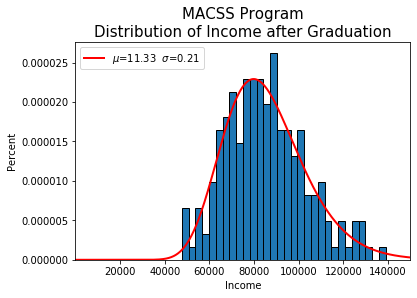

In [9]:
# Plot the estimated lognormal PDF against the data

# data histogram
num_bins = 30
plt.hist(incomes, num_bins, density=True, edgecolor='k') # `normed` argument has been deprecated by `matplotlib.pyplot.hist`
plt.title('MACSS Program\nDistribution of Income after Graduation', fontsize=15)
plt.xlabel(r'Income')
plt.ylabel(r'Percent')
plt.xlim([1, 150000])

# pdf plot
dis_pts = np.linspace(cut_lb, cut_ub, 1000)
plt.plot(dis_pts, trunc_lognorm_pdf(dis_pts, mu_GMM1_2, sig_GMM1_2, cut_lb, cut_ub),
         linewidth=2, color='r', label=f'$\mu$={round(mu_GMM1_2, 2)}  $\sigma$={round(sig_GMM1_2, 2)}')
plt.legend(loc='upper left')
plt.show()

## Problem 1.c

Two-step GMM
- R (No. of moment conditions): 2 
- Moment conditions
    - mean
    - standard deviation
- Weighting matrix: $\hat{\Omega}_{2step}$

> Note: In Dr.Evan's notebook, the definition of `get_Err_mat` function is different from the mathematical formula. Here I stick to the theoretical formula, where the each element in the matrix is $ \mathrm{modelmoment} - \mathrm{datamoment} $ or $ \frac{\mathrm{modelmoment} - \mathrm{datamoment}}{\mathrm{datamoment}} $. 

In [10]:
# Define a functions that computes the R x N matrix of errors 
# from each observation for each moment. 
def get_Err_mat2(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 2
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_data, var_data = data_moments(pts)
    mean_model, var_model = model_moments(mu, sigma, cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = mean_model - pts
        Err_mat[1, :] = var_model - ((mean_data - pts) ** 2)
    else:
        Err_mat[0, :] = (mean_model - pts) / mean_data
        Err_mat[1, :] = (var_model - ((mean_data - pts) ** 2)) / var_data
    
    return Err_mat

In [11]:
# Calculate the Variance Covariance Matrix of error from the first GMM 
# and the 2 step optimal Weighting Matrix
Err_mat = get_Err_mat2(incomes, mu_GMM1_2, sig_GMM1_2, cut_lb, cut_ub, simple=False)
VCV2 = (1 / incomes.shape[0]) * (Err_mat @ Err_mat.T)
print('Variance Covariance Matrix: \n', VCV2)
W_hat2_2 = lin.inv(VCV2)
print('Weighting Matrix: \n', W_hat2_2)

Variance Covariance Matrix: 
 [[4.45167064e-02 1.67963793e+03]
 [1.67963793e+03 9.49413378e+08]]
Weighting Matrix: 
 [[ 2.40701667e+01 -4.25833109e-05]
 [-4.25833109e-05  1.12861749e-09]]


In [12]:
# Perform GMM with R = 2, W = VCV^-1
mu_init = mu_GMM1_2
sig_init = sig_GMM1_2
cut_lb = 0.0
cut_ub = 150000.0
params_init = np.array([mu_init, sig_init])
gmm_args = (incomes, cut_lb, cut_ub, W_hat2_2)
results2_2 = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM2_2, sig_GMM2_2 = results2_2.x
results2_2

      fun: array([[4.27941551e-16]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.85931329e-08, -1.86302364e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 9
      nit: 1
   status: 0
  success: True
        x: array([11.33353347,  0.21386191])

In [13]:
# Print the result
print('mu_GMM2_2 =', mu_GMM2_2, ' sig_GMM2_2 =', sig_GMM2_2)
print()
print('Sample Mean = ', data_moments(incomes)[0])
print('Model Mean = ', model_moments(mu_GMM2_2, sig_GMM2_2, cut_lb, cut_ub)[0])
print()
print('Sample Variation = ', data_moments(incomes)[1])
print('Model Variation = ', model_moments(mu_GMM2_2, sig_GMM2_2, cut_lb, cut_ub)[1])
print()
print('Error vector = ',  err_vec(incomes, mu_GMM2_2, sig_GMM2_2, cut_lb, cut_ub, simple=False).reshape(2))
print()
print('Value of GMM criterion function at the estimated parameter = ', results2_2.fun[0][0])

mu_GMM2_2 = 11.333533472755567  sig_GMM2_2 = 0.2138619137414822

Sample Mean =  85276.82360625808
Model Mean =  85276.82324668269

Sample Variation =  18037.692869371564
Model Variation =  18037.692248481544

Error vector =  [-4.21656647e-09 -3.44218090e-08]

Value of GMM criterion function at the estimated parameter =  4.27941551143365e-16


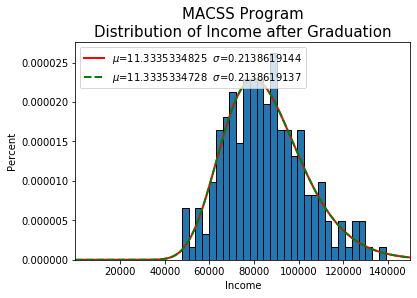

In [14]:
# Plot the estimated lognormal PDF against the data

# data histogram
num_bins = 30
plt.hist(incomes, num_bins, density=True, edgecolor='k') # `normed` argument has been deprecated by `matplotlib.pyplot.hist`
plt.title('MACSS Program\nDistribution of Income after Graduation', fontsize=15)
plt.xlabel(r'Income')
plt.ylabel(r'Percent')
plt.xlim([1, 150000])

# pdf plot for GMM1 result
dis_pts = np.linspace(cut_lb, cut_ub, 1000)
plt.plot(dis_pts, trunc_lognorm_pdf(dis_pts, mu_GMM1_2, sig_GMM1_2, cut_lb, cut_ub),
         linewidth=2, color='r', label=f'$\mu$={round(mu_GMM1_2, 10)}  $\sigma$={round(sig_GMM1_2, 10)}')

# pdf plot for GMM2 result
dis_pts = np.linspace(cut_lb, cut_ub, 1000)
plt.plot(dis_pts, trunc_lognorm_pdf(dis_pts, mu_GMM2_2, sig_GMM2_2, cut_lb, cut_ub),
         linewidth=2, color='g', label=f'$\mu$={round(mu_GMM2_2, 10)}  $\sigma$={round(sig_GMM2_2, 10)}', ls='--')
plt.legend(loc='upper left')
plt.show()

The estimation is very close to that of the previous estimation. 

## Problem 1.d

GMM 
- R (No. of moment conditions): 4
- Moment conditions: percentiles
- Weighting matrix: the identity matrix

In [15]:
# Define the functions that calculate 
# data and model moment, the error vector, and the criterion

def data_moments3(xvals):

    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat


def model_moments3(mu, sigma, cut_lb, cut_ub):
 
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 150000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod


def err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple):
 
    bpct_1_dat, bpct_2_dat, bpct_3_dat = \
        data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = \
        model_moments3(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion3(params, *args):
   
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err 
    
    return crit_val

In [16]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat1_3 = np.eye(3)
gmm_args = (incomes, cut_lb, cut_ub, W_hat1_3)
results1_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1_3, sig_GMM1_3 = results1_3.x
results1_3

      fun: array([[4.29613941e-13]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.32712305e-06,  3.97853224e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 102
      nit: 20
   status: 0
  success: True
        x: array([11.33670511,  0.21151358])

In [17]:
# Print the result
print('mu_GMM2_3 =', mu_GMM1_3, ' sig_GMM2_3 =', sig_GMM1_3)
print()
print('Percent of Individuals')
print('data moment %<75,000\n', data_moments3(incomes)[0])
print('model moment %<75,000\n', model_moments3(mu_GMM1_3, sig_GMM1_3, cut_lb, cut_ub)[0])
print()
print('data moment %>75,000, <100000\n', data_moments3(incomes)[1])
print('model moment %>75,000, <100000\n', model_moments3(mu_GMM1_3, sig_GMM1_3, cut_lb, cut_ub)[1])
print()
print('data moment %>100000\n', data_moments3(incomes)[2])
print('model moment %>100000\n', model_moments3(mu_GMM1_3, sig_GMM1_3, cut_lb, cut_ub)[2])
print()
print('Error vector = ',  err_vec3(incomes, mu_GMM1_3, sig_GMM1_3, cut_lb, cut_ub, simple=False).reshape(3))
print()
print('Value of GMM criterion function at the estimated parameter = ', results1_3.fun[0][0])

mu_GMM2_3 = 11.336705110698398  sig_GMM2_3 = 0.21151357583827635

Percent of Individuals
data moment %<75,000
 0.3
model moment %<75,000
 0.30000017044855387

data moment %>75,000, <100000
 0.5
model moment %>75,000, <100000
 0.4999998681752989

data moment %>100000
 0.2
model moment %>100000
 0.19999996137614728

Error vector =  [ 5.68161846e-07 -2.63649402e-07 -1.93119264e-07]

Value of GMM criterion function at the estimated parameter =  4.2961394082900814e-13


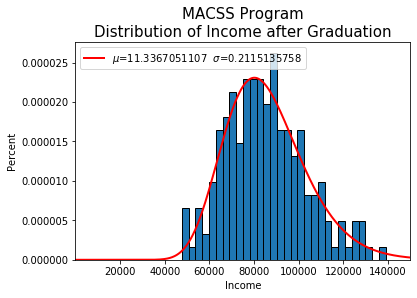

In [18]:
# Plot the estimated lognormal PDF against the data

# data histogram
num_bins = 30
plt.hist(incomes, num_bins, density=True, edgecolor='k') # `normed` argument has been deprecated by `matplotlib.pyplot.hist`
plt.title('MACSS Program\nDistribution of Income after Graduation', fontsize=15)
plt.xlabel(r'Income')
plt.ylabel(r'Percent')
plt.xlim([1, 150000])

# pdf plot for GMM3 result
dis_pts = np.linspace(cut_lb, cut_ub, 1000)
plt.plot(dis_pts, trunc_lognorm_pdf(dis_pts, mu_GMM1_3, sig_GMM1_3, cut_lb, cut_ub),
         linewidth=2, color='r', label=f'$\mu$={round(mu_GMM1_3, 10)}  $\sigma$={round(sig_GMM1_3, 10)}')
plt.legend(loc='upper left')
plt.show()

> Note: In Dr.Evan's notebook, the definition of `get_Err_mat` function is different from the mathematical formula. Here I stick to the theoretical formula, where the each element in the matrix is $ \mathrm{modelmoment} - \mathrm{datamoment} $ or $ \frac{\mathrm{modelmoment} - \mathrm{datamoment}}{\mathrm{datamoment}} $. 

In [19]:
# Define a functions that computes the R x N matrix of errors 
# from each observation for each moment. 
def get_Err_mat3(pts, mu, sigma, cut_lb, cut_ub, simple=False):

    R = 3
    N = len(pts)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = \
        model_moments3(mu, sigma, cut_lb, cut_ub)
    if simple:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = pct_1_mod - pts_in_grp1
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = pct_2_mod - pts_in_grp2
        pts_in_grp3 = (pts >= 100000)
        Err_mat[2, :] = pct_3_mod - pts_in_grp3 
    else:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = (pct_1_mod - pts_in_grp1) / pts_in_grp1
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = (pct_2_mod - pts_in_grp2) / pts_in_grp2
        pts_in_grp3 = (pts >= 100000)
        Err_mat[2, :] = (pct_3_mod - pts_in_grp3) / pts_in_grp3
    
    return Err_mat

In [20]:
# Calculate the Variance Covariance Matrix of error from the first GMM 
# and the 2 step optimal Weighting Matrix
Err_mat3 = get_Err_mat3(incomes, mu_GMM1_3, sig_GMM1_3, cut_lb, cut_ub, simple=True)
VCV2_3 = (1 / incomes.shape[0]) * (Err_mat3 @ Err_mat3.T)
print('Variance Covariance Matrix: \n', VCV2_3)
# We use the pseudo-inverse command here because the VCV matrix is poorly conditioned
W_hat2_3 = lin.pinv(VCV2_3)
print('Weighting Matrix: \n', W_hat2_3)

Variance Covariance Matrix: 
 [[ 0.21 -0.15 -0.06]
 [-0.15  0.25 -0.1 ]
 [-0.06 -0.1   0.16]]
Weighting Matrix: 
 [[ 2.25925926 -0.62962963 -1.62962963]
 [-0.62962963  1.81481481 -1.18518519]
 [-1.62962963 -1.18518519  2.81481481]]


In [21]:
mu_init = mu_GMM1_3
sig_init = sig_GMM1_3
params_init = np.array([mu_init, sig_init])
gmm_args = (incomes, cut_lb, cut_ub, W_hat2_3)
results2_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2_3, sig_GMM2_3 = results2_3.x
results2_3

      fun: array([[2.48734368e-13]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.74735161e-06, 1.15212111e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 9
      nit: 1
   status: 0
  success: True
        x: array([11.33670517,  0.21151357])

In [22]:
# Print the result
print('mu_GMM2_3 =', mu_GMM2_3, ' sig_GMM2_3 =', sig_GMM2_3)
print()
print('Percent of Individuals')
print('data moment %<75,000\n', data_moments3(incomes)[0])
print('model moment %<75,000\n', model_moments3(mu_GMM2_3, sig_GMM2_3, cut_lb, cut_ub)[0])
print()
print('data moment %>75,000, <100000\n', data_moments3(incomes)[1])
print('model moment %>75,000, <100000\n', model_moments3(mu_GMM2_3, sig_GMM2_3, cut_lb, cut_ub)[1])
print()
print('data moment %>100000\n', data_moments3(incomes)[2])
print('model moment %>100000\n', model_moments3(mu_GMM2_3, sig_GMM2_3, cut_lb, cut_ub)[2])
print()
print('Error vector = ',  err_vec3(incomes, mu_GMM2_3, sig_GMM2_3, cut_lb, cut_ub, simple=False).reshape(3))
print()
print('Value of GMM criterion function at the estimated parameter = ', results2_3.fun[0][0])

mu_GMM2_3 = 11.336705169978407  sig_GMM2_3 = 0.2115135669478794

Percent of Individuals
data moment %<75,000
 0.3
model moment %<75,000
 0.30000006557965947

data moment %>75,000, <100000
 0.5
model moment %>75,000, <100000
 0.49999990488958057

data moment %>100000
 0.2
model moment %>100000
 0.2000000295307601

Error vector =  [ 2.18598865e-07 -1.90220839e-07  1.47653800e-07]

Value of GMM criterion function at the estimated parameter =  2.487343684983694e-13


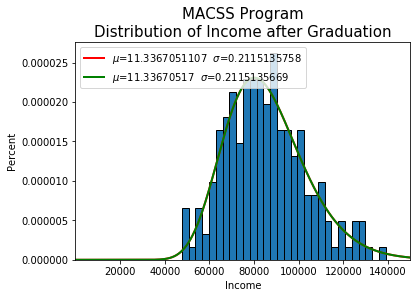

In [23]:
# Plot the estimated lognormal PDF against the data

# data histogram
num_bins = 30
plt.hist(incomes, num_bins, density=True, edgecolor='k') # `normed` argument has been deprecated by `matplotlib.pyplot.hist`
plt.title('MACSS Program\nDistribution of Income after Graduation', fontsize=15)
plt.xlabel(r'Income')
plt.ylabel(r'Percent')
plt.xlim([1, 150000])

# pdf plot for GMM1_3 result
dis_pts = np.linspace(cut_lb, cut_ub, 1000)
plt.plot(dis_pts, trunc_lognorm_pdf(dis_pts, mu_GMM1_3, sig_GMM1_3, cut_lb, cut_ub),
         linewidth=2, color='r', label=f'$\mu$={round(mu_GMM1_3, 10)}  $\sigma$={round(sig_GMM1_3, 10)}')

# pdf plot for GMM2_3 result
dis_pts = np.linspace(cut_lb, cut_ub, 1000)
plt.plot(dis_pts, trunc_lognorm_pdf(dis_pts, mu_GMM2_3, sig_GMM2_3, cut_lb, cut_ub),
         linewidth=2, color='g', label=f'$\mu$={round(mu_GMM2_3, 10)}  $\sigma$={round(sig_GMM2_3, 10)}')
plt.legend(loc='upper left')
plt.show()

## Problem 1.f

In [24]:
mu_GMM_list = [mu_GMM1_2, mu_GMM2_2, mu_GMM1_3, mu_GMM2_3]
sig_GMM_list = [sig_GMM1_2, sig_GMM2_2, sig_GMM1_3, sig_GMM2_3]
fun_list = [results1_2.fun, results2_2.fun, results1_3.fun, results2_3.fun]
pd.DataFrame(data={"mu_GMM":mu_GMM_list, 
              "sigma_GMM":sig_GMM_list, 
              "Criterion function value": fun_list}, 
             index=['R=2 identity', 
                    'R=2 2step', 
                    'R=3 identity', 
                    'R=3 2step']).astype(float)

,mu_GMM,sigma_GMM,Criterion function value
R=2 identity,11.333533,0.213862,6.357629e-16
R=2 2step,11.333533,0.213862,4.279416e-16
R=3 identity,11.336705,0.211514,4.296139e-13
R=3 2step,11.336705,0.211514,2.487344e-13


The four GMM models above give very similar results, all of which fit the data well. To decide which is the best estimate, we have to find a reasonable measurement of the quality of estimation. Here we can get the criterion function value of each result. However, since the weighting matrices and the moment conditions are different, comparing the criterion function value reveals nothing useful about the quality of estimation. 

I turn to use the variance-covariance matrix and try to evaluate the reliability of estimation by comparing the standard error of the estiamted parameters. Since the standard error is comparable across different methods, I argue that this is a reasonable criterion to evaluate different results. 

In [25]:
def Jac_err2(xvals, mu, sigma, cut_lb, cut_ub, simple=True):
    '''
    This function computes the Jacobian matrix of partial derivatives of the R x 1 moment
    error vector e(x|theta) with respect to the K parameters theta_i in the K x 1 parameter vector
    theta. The resulting matrix is R x K Jacobian.
    '''
    Jac_err = np.zeros((2, 2))
    h_mu = 1e-8 * mu
    h_sig = 1e-8 * sigma
    Jac_err[:, 0] = \
        ((err_vec(xvals, mu + h_mu, sigma, cut_lb, cut_ub, simple) -
          err_vec(xvals, mu - h_mu, sigma, cut_lb, cut_ub, simple)) / (2 * h_mu)).flatten()
    Jac_err[:, 1] = \
        ((err_vec(xvals, mu, sigma + h_sig, cut_lb, cut_ub, simple) -
          err_vec(xvals, mu, sigma - h_sig, cut_lb, cut_ub, simple)) / (2 * h_sig)).flatten()
    
    return Jac_err

In [26]:
def Jac_err3(xvals, mu, sigma, cut_lb, cut_ub, simple=False):
    '''
    This function computes the Jacobian matrix of partial derivatives of the R x 1 moment
    error vector e(x|theta) with respect to the K parameters theta_i in the K x 1 parameter vector
    theta. The resulting matrix is R x K Jacobian.
    '''
    Jac_err = np.zeros((3, 2))
    h_mu = 1e-8 * mu
    h_sig = 1e-8 * sigma
    Jac_err[:, 0] = \
        ((err_vec3(xvals, mu + h_mu, sigma, cut_lb, cut_ub, simple) -
          err_vec3(xvals, mu - h_mu, sigma, cut_lb, cut_ub, simple)) / (2 * h_mu)).flatten()
    Jac_err[:, 1] = \
        ((err_vec3(xvals, mu, sigma + h_sig, cut_lb, cut_ub, simple) -
          err_vec3(xvals, mu, sigma - h_sig, cut_lb, cut_ub, simple)) / (2 * h_sig)).flatten()
    
    return Jac_err

In [27]:
print('Moment condition: mu, var\nWeighting matrix: identity\n')
print('Estimated parameters: ', mu_GMM1_2, sig_GMM1_2)
N = incomes.shape[0]
d_err2 = Jac_err2(incomes, mu_GMM1_2, sig_GMM1_2, 0.0, 450.0, True)
SigHatSqr1_2 = (1 / N) * lin.inv(d_err2.T @ W_hat1_2 @ d_err2)
print('Variance-covariance matrix of the estimated parameters: ')
print(SigHatSqr1_2)
print('Std. err. mu_hat=', np.sqrt(SigHatSqr1_2[0, 0]))
print('Std. err. sig_hat=', np.sqrt(SigHatSqr1_2[1, 1]))

Moment condition: mu, var
Weighting matrix: identity

Estimated parameters:  11.333533482547018 0.21386191435240126
Variance-covariance matrix of the estimated parameters: 
[[4.25158254e+03 8.66871292e+01]
 [8.66871292e+01 1.76749873e+00]]
Std. err. mu_hat= 65.204160460001
Std. err. sig_hat= 1.3294731038863856


In [28]:
print('Moment condition: mu, var\nWeighting matrix: 2-step\n')
print('Estimated parameters: ', mu_GMM2_2, sig_GMM2_2)
N = incomes.shape[0]
d_err2 = Jac_err2(incomes, mu_GMM2_2, sig_GMM2_2, 0.0, 450.0, True)
SigHatSqr2_2 = (1 / N) * lin.inv(d_err2.T @ W_hat2_2 @ d_err2)
print('Variance-covariance matrix of the estimated parameters: ')
print(SigHatSqr2_2)
print('Std. err. mu_hat=', np.sqrt(SigHatSqr2_2[0, 0]))
print('Std. err. sig_hat=', np.sqrt(SigHatSqr2_2[1, 1]))

Moment condition: mu, var
Weighting matrix: 2-step

Estimated parameters:  11.333533472755567 0.2138619137414822
Variance-covariance matrix of the estimated parameters: 
[[1.80096183e+12 3.67223615e+10]
 [3.67223615e+10 7.48784240e+08]]
Std. err. mu_hat= 1341999.19276735
Std. err. sig_hat= 27363.922229332427


In [29]:
print('Moment condition: percentages\nWeighting matrix: identity\n')
print('Estimated parameters: ', mu_GMM1_3, sig_GMM1_3)
N = incomes.shape[0]
d_err3 = Jac_err3(incomes, mu_GMM1_3, sig_GMM1_3, 0.0, 450.0, False)
SigHatSqr1_3 = (1 / N) * lin.inv(d_err3.T @ W_hat1_3 @ d_err3)
print('Variance-covariance matrix of the estimated parameters: ')
print(SigHatSqr1_3)
print('Std. err. mu_hat=', np.sqrt(SigHatSqr1_3[0, 0]))
print('Std. err. sigma_hat=', np.sqrt(SigHatSqr1_3[1, 1]))

Moment condition: percentages
Weighting matrix: identity

Estimated parameters:  11.336705110698398 0.21151357583827635
Variance-covariance matrix of the estimated parameters: 
[[9.66183399e-274 3.92890796e-275]
 [3.92890796e-275 1.60045397e-276]]
Std. err. mu_hat= 3.1083490778146143e-137
Std. err. sigma_hat= 1.265090500368414e-138


In [30]:
print('Moment condition: percentages\nWeighting matrix: 2-step\n')
print('Estimated parameters: ', mu_GMM2_3, sig_GMM2_3)
N = incomes.shape[0]
d_err3 = Jac_err3(incomes, mu_GMM2_3, sig_GMM2_3, 0.0, 450.0, False)
SigHatSqr2_3 = (1 / N) * lin.inv(d_err3.T @ W_hat2_3 @ d_err3)
print('Variance-covariance matrix of the estimated parameters: ')
print(SigHatSqr2_3)
print('Std. err. mu_hat=', np.sqrt(SigHatSqr2_3[0, 0]))
print('Std. err. sigma_hat=', np.sqrt(SigHatSqr2_3[1, 1]))

Moment condition: percentages
Weighting matrix: 2-step

Estimated parameters:  11.336705169978407 0.2115135669478794
Variance-covariance matrix of the estimated parameters: 
[[ 2.77202986e-274 -1.60908416e-274]
 [-1.60908416e-274  6.26869191e-274]]
Std. err. mu_hat= 1.6649413979602055e-137
Std. err. sigma_hat= 2.5037355920225113e-137


In [31]:
# Compare the standard errors
mu_GMM_list = [mu_GMM1_2, mu_GMM2_2, mu_GMM1_3, mu_GMM2_3]
sig_GMM_list = [sig_GMM1_2, sig_GMM2_2, sig_GMM1_3, sig_GMM2_3]
mu_stderr_list = [np.sqrt(SigHatSqr1_2[0, 0]), np.sqrt(SigHatSqr2_2[0, 0]), np.sqrt(SigHatSqr1_3[0, 0]), np.sqrt(SigHatSqr2_3[0, 0])]
sig_stderr_list = [np.sqrt(SigHatSqr1_2[1, 1]), np.sqrt(SigHatSqr2_2[1, 1]), np.sqrt(SigHatSqr1_3[1, 1]), np.sqrt(SigHatSqr2_3[1, 1])]
pd.DataFrame(data={"mu_GMM": mu_GMM_list, 
                   "sigma_GMM": sig_GMM_list, 
                   "Criterion function value": fun_list, 
                   "mu_hat_stderr": mu_stderr_list, 
                   "sigma_hat_stderr": sig_stderr_list}, 
             index=['R=2 identity', 
                    'R=2 2step', 
                    'R=3 identity', 
                    'R=3 2step']).astype(float)

,mu_GMM,sigma_GMM,Criterion function value,mu_hat_stderr,sigma_hat_stderr
R=2 identity,11.333533,0.213862,6.357629e-16,6.520416e+01,1.329473e+00
R=2 2step,11.333533,0.213862,4.279416e-16,1.341999e+06,2.736392e+04
R=3 identity,11.336705,0.211514,4.296139e-13,3.108349e-137,1.265091e-138
R=3 2step,11.336705,0.211514,2.487344e-13,1.664941e-137,2.503736e-137


In terms of standard error of the estimated parameters, the overidentified model with 2-step optimized weighting matrix gives the most reliable estimation. 

# Problem 2

GMM Regression (OLS): 

- Moment conditions: $ y_i = \hat{y}_i $
- weighting matrix: identity

## Problem 2.1

In [32]:
reg_data = pd.read_csv("data/sick.txt").astype('float64')
reg_data['constant'] = 1
reg_data.head()

,sick,age,children,avgtemp_winter,constant
0,1.67,57.47,3.04,54.10,1
1,0.71,26.77,1.20,36.54,1
2,1.39,41.85,2.31,32.38,1
3,1.37,51.27,2.46,52.94,1
4,1.45,44.22,2.72,45.90,1


In [33]:
y_vals = reg_data['sick']
x_matrix = np.array(reg_data[['constant', 'age', 'children', 'avgtemp_winter']])

In [34]:
def reg_data_moment(y_vals): 
    return y_vals


def reg_model_moment(x_matrix, beta_array): 
    return x_matrix @ beta_array


def reg_err_vec(y_vals, x_matrix, beta_array): 
    err_vec = y_vals - reg_model_moment(x_matrix, beta_array)
    return err_vec
    
def reg_criterion(beta_array, *args): 
    y_vals, x_matrix, W = args
    err_vec = reg_err_vec(y_vals, x_matrix, beta_array)
    return err_vec.T @ W @ err_vec

In [35]:
beta_init = 0, 0, 0, 1
params_init = np.array([beta_init])
W_hat_reg = np.eye(200)
gmm_args = (y_vals, x_matrix, W_hat_reg)
results_reg = opt.minimize(reg_criterion, params_init, args=(gmm_args))
beta0, beta1, beta2, beta3 = results_reg.x
results_reg

      fun: 0.0018212901365903104
 hess_inv: array([[ 0.05280023,  0.00043396, -0.00904332, -0.00119906],
       [ 0.00043396,  0.00022671, -0.00202805, -0.00014215],
       [-0.00904332, -0.00202805,  0.0208247 ,  0.00128679],
       [-0.00119906, -0.00014215,  0.00128679,  0.0001096 ]])
      jac: array([7.27595761e-10, 3.93338269e-08, 7.85803422e-10, 4.27098712e-08])
  message: 'Optimization terminated successfully.'
     nfev: 72
      nit: 9
     njev: 12
   status: 0
  success: True
        x: array([ 0.25164638,  0.01293335,  0.40050205, -0.00999167])

In [36]:
print('Estimation Result: \n')
print('VARIABLES', ' ' * 6, 'GNN Estimation')
print('-'*40)
i = 0
beta_print = [beta1, beta2, beta3, beta0]
for column_name, column_data in reg_data[['age', 'children', 'avgtemp_winter', 'constant']].iteritems(): 
    print(column_name, ' ' * (15 - len(column_name)), beta_print[i], '\n')
    i += 1

print('Criterion Function Value: ', - results_reg.fun)

Estimation Result: 

VARIABLES        GNN Estimation
----------------------------------------
age              0.012933350043983783 

children         0.4005020483142437 

avgtemp_winter   -0.009991673035018273 

constant         0.25164638359384617 

Criterion Function Value:  -0.0018212901365903104
